#**Analyse des sentiments**

examiner des données rares et travailler avec les représentations vectorielles continues à l'aide de données textuelles issues de critiques de films (provenant de l'ensemble de données IMDB ACL 2011). 

On va effectuer, sur ces données, l'entraînement d'un modèle d'analyse des sentiments qui prédit si une critique est globalement favorable (libellé 1) ou défavorable (libellé 0).


Pour ce faire, on va transformer la valeur de chaîne terms en vecteurs de caractéristiques en utilisant un vocabulaire, c'est-à-dire une liste de termes que vous vous attendez à trouver dans nos données.

Pour les besoins de cet exercice, nous avons créé un vocabulaire réduit qui porte sur un ensemble limité de termes. Il s'est avéré que la plupart de ces termes indiquaient clairement un fort sentiment favorable ou défavorable. D'autres cependant ont simplement été ajoutés, car ils étaient intéressants.

Chaque terme du vocabulaire est associé à une coordonnée du vecteur de caractéristiques. Pour convertir la valeur de chaîne terms d'un exemple dans ce format de vecteur, vous allez coder comme suit :

chaque coordonnée reçoit la valeur 0 si le terme de vocabulaire ne figure pas dans l'exemple de chaîne, et la valeur 1 dans le cas contraire. Les termes qui ne figurent pas dans le vocabulaire sont rejetés.

In [1]:
# Chargement des données

from __future__ import print_function

import collections
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%tensorflow_version 1.x
import tensorflow as tf
from IPython import display
from sklearn import metrics


# Eviter de print tous les warnings et les erreurs 
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Option d'affichage des données contenues dans le dataframe 
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 1000)

train_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)

print('Les datasets sont déjà créés, formatés et prêt à l\'emploi')

TensorFlow 1.x selected.
40689664/40688441 [==============================] - 0s 0us/step
Les datasets sont déjà créés, formatés et prêt à l'emploi


On va commencer par créer le pipeline d'entrée pour importer les données dans un modèle TensorFlow.

On va utiliser la fonction suivante pour analyser les données de test et d'apprentissage (qui se trouvent au format TFRecord), et renvoyer un dictionnaire des caractéristiques et les libellés correspondants.

In [2]:
def _parse_function(record):
  
  """Son objectifs et d'extraire les features et les labels
  
  Args:
    Son argument est un lien vers un fichier type TFRecord file    
  Retour:
    Elle renvoie le couple: `(labels, features)`:
      features: Un dictionnaire de tensors( matrices de données ) representant les features 
      labels: un tensor( matrices de données ) representant les labels correspondant
  """
  features = {
    "terms": tf.VarLenFeature(dtype=tf.string), # terms are strings of varying lengths
    "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32) # labels are 0 or 1
  }

  
  
  parsed_features = tf.parse_single_example(record, features)

  # print(parsed_features)
  
  terms = parsed_features['terms'].values
  labels = parsed_features['labels']


  return  {'terms':terms}, labels




Pour vérifier que cela fonctionne comme prévu, on construit un ensemble TFRecordDataset pour les données d'apprentissage, et on associe ces dernières aux caractéristiques et aux libellés à l'aide de la fonction ci-dessus.

In [3]:
# Pour l'exemple on va creer un dataset en chargeant les données 
ds = tf.data.TFRecordDataset(train_path)

# On map les features et labels avec la fonction parse.
# This transformation applies the mapped function to each element of this dataset, and returns a new dataset containing the transformed elements,
#  in the same order as they appeared in the input. the mapped function can be used to change both the values and the structure of a dataset's elements.
#  For example, adding 1 to each element, or projecting a subset of element components.

ds = ds.map(_parse_function)

# On vient d'appliquer la fonction sur toutes les données contenues dans le dataset 
ds

<DatasetV1Adapter shapes: ({terms: (?,)}, (1,)), types: ({terms: tf.string}, tf.float32)>

Récupérons le premier exemple de l'ensemble de données d'apprentissage.



In [4]:
n = ds.make_one_shot_iterator().get_next()

"""
  A session allows to execute graphs or part of graphs.
  It allocates resources (on one or more machines) for that and
  holds the actual values of intermediate results and variables.
"""

sess = tf.Session()
sess.run(n)

# On voit alors 

({'terms': array([b'but', b'it', b'does', b'have', b'some', b'good', b'action',
         b'and', b'a', b'plot', b'that', b'is', b'somewhat', b'interesting',
         b'.', b'nevsky', b'acts', b'like', b'a', b'body', b'builder',
         b'and', b'he', b'isn', b"'", b't', b'all', b'that', b'attractive',
         b',', b'in', b'fact', b',', b'imo', b',', b'he', b'is', b'ugly',
         b'.', b'(', b'his', b'acting', b'skills', b'lack', b'everything',
         b'!', b')', b'sascha', b'is', b'played', b'very', b'well', b'by',
         b'joanna', b'pacula', b',', b'but', b'she', b'needed', b'more',
         b'lines', b'than', b'she', b'was', b'given', b',', b'her',
         b'character', b'needed', b'to', b'be', b'developed', b'.',
         b'there', b'are', b'way', b'too', b'many', b'men', b'in', b'this',
         b'story', b',', b'there', b'is', b'zero', b'romance', b',', b'too',
         b'much', b'action', b',', b'and', b'way', b'too', b'dumb', b'of',
         b'an', b'ending', b'.', b'

On va maintenant creer une fonction qui va permettre de parser les données et de les diviser en features et labels


In [5]:
def _input_fn(input_filenames, num_epochs=None, shuffle=True):
  
  # Comme l'exemple d'avant; on crée un dataset et on map les features et labels.
  ds = tf.data.TFRecordDataset(input_filenames)
  # on applique la fonction à l'ensemble des donneés 
  ds = ds.map(_parse_function)

  if shuffle:
    ds = ds.shuffle(10000)

  # Our feature data is variable-length, so we pad and batch
  # each field of the dataset structure to whatever size is necessary.     
  ds = ds.padded_batch(25, ds.output_shapes)
  
  ds = ds.repeat(num_epochs)

  
  # Renvoie le bacth de données suivant ( batch features , batch labels)
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

  

On  commence par 50 termes informatifs.

Le code suivant construit la colonne de caractéristiques pour ces termes. La fonction categorical_column_with_vocabulary_list crée une colonne de caractéristiques avec la mise en correspondance chaîne/vecteur de caractéristiques.


In [6]:
# 50 informative terms that compose our model vocabulary. 
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family")

terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", vocabulary_list=informative_terms)

On va maintenant définir le modèle de réseau de neurones et l'entrainer 

In [7]:
#Creation du modèle !
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(                                      
  feature_columns=[tf.feature_column.indicator_column(terms_feature_column)], 
  hidden_units=[20,20],                                                       
  optimizer=my_optimizer,                                                     
)                                                                             


try:
  # Pas de boucle d'apprentissage cette fois ci; On appelle la methode train sur le modèle une seule fois 

  classifier.train(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)

  # On evalue le modèle avec les données d'entrainement/
  # PAs de séparation des données avec les données de validation et données de test
  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([train_path]),
    steps=1)
  
  print("Training set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")

  # On evalue le modèle avec les données de test non connues par le modèle
  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([test_path]),
    steps=1)

  print("Test set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")

except ValueError as err:
  print(err)

Training set metrics:
accuracy 0.84
accuracy_baseline 0.6
auc 0.9066666
auc_precision_recall 0.92889965
average_loss 0.3753662
label/mean 0.6
loss 9.384155
precision 0.8666667
prediction/mean 0.5737347
recall 0.8666667
global_step 1000
---
Test set metrics:
accuracy 0.68
accuracy_baseline 0.68
auc 0.7720587
auc_precision_recall 0.51754194
average_loss 0.6340933
label/mean 0.32
loss 15.852332
precision 0.5
prediction/mean 0.4346596
recall 0.75
global_step 1000
---


Dans le cadre de cette tâche, on va mettre en œuvre un modèle DNN à l'aide d'une colonne de représentations vectorielles continues. Une colonne de ce type accepte des données rares en guise d'entrée et renvoie un vecteur dense de plus faible dimension en sortie.

REMARQUE : En règle générale, une colonne de représentations vectorielles continues constitue l'option la plus efficace du point de vue de l'utilisation des ressources pour entraîner un modèle sur des données rares

In [8]:
#Nouveau code avec representation vectorielle continue 

# tf.feature_column.embedding_column()
# Use this when your inputs are sparse, but you want to convert them to a dense representation (e.g., to feed to a DNN).
# Inputs must be a CategoricalColumn created by any of the categorical_column_* function.

# Supposons qu'au lieu de n'avoir que quelques chaînes possibles, nous avons des milliers (ou plus) de valeurs par catégorie.
# Pour un certain nombre de raisons, à mesure que le nombre de catégories augmente, il devient impossible d'entraîner
# un réseau de neurones à l'aide d'encodages one-hot. Nous pouvons utiliser une colonne d'intégration pour surmonter
# cette limitation. Au lieu de représenter les données comme un vecteur unique de plusieurs dimensions,
# une colonne d'intégration représente ces données comme un vecteur dense de dimension inférieure
# dans lequel chaque cellule peut contenir n'importe quel nombre, pas seulement 0 ou 1.
# La taille de l'incorporation ( 8, dans l'exemple ci-dessous) est un paramètre qui doit être réglé.



terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)


feature_columns = [ terms_embedding_column ]

print(feature_columns)

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[20,20],
  optimizer=my_optimizer
)


classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

[EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='terms', vocabulary_list=('bad', 'great', 'best', 'worst', 'fun', 'beautiful', 'excellent', 'poor', 'boring', 'awful', 'terrible', 'definitely', 'perfect', 'liked', 'worse', 'waste', 'entertaining', 'loved', 'unfortunately', 'amazing', 'enjoyed', 'favorite', 'horrible', 'brilliant', 'highly', 'simple', 'annoying', 'today', 'hilarious', 'enjoyable', 'dull', 'fantastic', 'poorly', 'fails', 'disappointing', 'disappointment', 'not', 'him', 'her', 'good', 'time', '?', '.', '!', 'movie', 'film', 'action', 'comedy', 'drama', 'family'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=2, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fa864f16750>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True)]
Training set metrics:
accuracy 0.77944
accuracy_baseline 0.5
auc 0.8677895
auc_precision_recall 0.85748696
average_loss 0.46289325
label/me

['dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adagrad', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adagrad', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adagrad', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adagrad', 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights', 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adagrad', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adagrad', 'global_step']


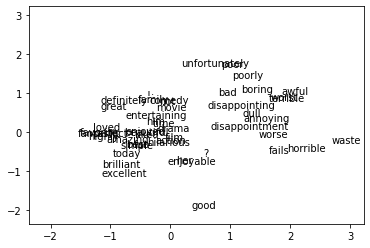

In [9]:
# voir la représentation vectorielle continue dont on a effectué l'apprentissage

import numpy as np
import matplotlib.pyplot as plt


print(classifier.get_variable_names())

embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
  # Create a one-hot encoding for our term.  It has 0s everywhere, except for
  # a single 1 in the coordinate that corresponds to that term.
  term_vector = np.zeros(len(informative_terms))
  term_vector[term_index] = 1
  # We'll now project that one-hot vector into the embedding space.
  embedding_xy = np.matmul(term_vector, embedding_matrix)
  plt.text(embedding_xy[0],
           embedding_xy[1],
           informative_terms[term_index])

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 

On distingue bien deux groupes de classification 

In [10]:
# On va essayer avec un vocabulaire beaucoup plus grand 

# vocabulary file
terms_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/terms.txt'
terms_path = tf.keras.utils.get_file(terms_url.split('/')[-1], terms_url)

253952/253538 [==============================] - 0s 0us/step


In [11]:
# Comme le fichier est un fichier txt et pas une fichier tfrecord , il faut l'ouvrir et le convertir de manière différente 

informative_terms = None
with io.open(terms_path, 'r', encoding='utf8') as f:
  # Convert it to a set first to remove duplicates.
  informative_terms = list(set(f.read().split()))

# On defini le type de features
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", 
                                                                                 vocabulary_list=informative_terms)

# On en fait un vecteur continu
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

# On defini le modèle :

my_optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[10,10],
  optimizer=my_optimizer
)

# On entraine:

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

# On teste le modèle :
evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")


Training set metrics:
accuracy 0.9548
accuracy_baseline 0.5
auc 0.98604435
auc_precision_recall 0.9834449
average_loss 0.14650296
label/mean 0.5
loss 3.662574
precision 0.9435169
prediction/mean 0.50942826
recall 0.96752
global_step 1000
---
Test set metrics:
accuracy 0.87704
accuracy_baseline 0.5
auc 0.945531
auc_precision_recall 0.94311917
average_loss 0.30142602
label/mean 0.5
loss 7.5356503
precision 0.86866397
prediction/mean 0.50554407
recall 0.8884
global_step 1000
---
